In [18]:
import os
import sys
py_files_dir = os.path.abspath("../../py_files/")
sys.path.insert(0, py_files_dir)

import matplotlib.pyplot as plt
import itertools
import helper_functions as funcs
import instrument_matrices as matrices
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import scipy_minimize_m3 as m3

In [1]:
import os
import shutil

def copy_files(file_list, dest_dir):
    """
    Copies files from their source paths to the destination directory, allowing overwrite.

    Args:
        file_list (list): List of full file paths to copy.
        dest_dir (str): Destination directory path.

    Returns:
        None
    """
    # Ensure destination directory exists
    os.makedirs(dest_dir, exist_ok=True)

    for src_file in file_list:
        file_name = os.path.basename(src_file)
        dest_file = os.path.join(dest_dir, file_name)

        try:
            shutil.copy2(src_file, dest_file)
            print(f"Copied {src_file} to {dest_file}")
        except FileNotFoundError:
            print(f"File not found: {src_file}")
        except Exception as e:
            print(f"Error copying {src_file} to {dest_file}: {e}")

# Example usage
file_list = [
    "/home/shared/exoserver/VAMPIRES/20220127/HD108767_01292022_Dark_Subtracted/rz_dpp/collapsed/20240111_HD108767_675_nm_Header_Parameters_R_15_Aperture_with_errors.csv",
    "/home/shared/exoserver/VAMPIRES/20220127/HD36819/rz_dpp/675/analysis/20240109_HD36819_675_nm_Header_Parameters_R_15_Aperture_with_errors.csv",
    "/home/shared/exoserver/VAMPIRES/20220127/eta_crv/rz_dpp/collapsed/20240111_Eta_Crv_675_nm_Header_Parameters_R_15_Aperture_with_errors.csv",
    "/home/shared/exoserver/Subaru/Vampires/Raw/20210714/HD128750/norm_675nm_em15/collapsed/20240122_HD128750_675_nm_Header_Parameters_R_15_Aperture_with_errors.csv",
    "/home/shared/exoserver/Subaru/Vampires/Raw/20210714/HD173667/norm_675_em1/collapsed/20240131_HD173667_675_nm_Header_Parameters_R_15_Aperture_with_errors.csv",
    "/home/shared/exoserver/Subaru/Vampires/Raw/20210714/HD173667/norm_675_em5/collapsed/20240201_HD173667_em5_675_nm_Header_Parameters_R_15_Aperture_with_errors.csv"
]

dest_dir = '../../data/unpolarized/' # Relative destination directory

copy_files(file_list, dest_dir)


Copied /home/shared/exoserver/VAMPIRES/20220127/HD108767_01292022_Dark_Subtracted/rz_dpp/collapsed/20240111_HD108767_675_nm_Header_Parameters_R_15_Aperture_with_errors.csv to ../../data/unpolarized/20240111_HD108767_675_nm_Header_Parameters_R_15_Aperture_with_errors.csv
Copied /home/shared/exoserver/VAMPIRES/20220127/HD36819/rz_dpp/675/analysis/20240109_HD36819_675_nm_Header_Parameters_R_15_Aperture_with_errors.csv to ../../data/unpolarized/20240109_HD36819_675_nm_Header_Parameters_R_15_Aperture_with_errors.csv
Copied /home/shared/exoserver/VAMPIRES/20220127/eta_crv/rz_dpp/collapsed/20240111_Eta_Crv_675_nm_Header_Parameters_R_15_Aperture_with_errors.csv to ../../data/unpolarized/20240111_Eta_Crv_675_nm_Header_Parameters_R_15_Aperture_with_errors.csv
Copied /home/shared/exoserver/Subaru/Vampires/Raw/20210714/HD128750/norm_675nm_em15/collapsed/20240122_HD128750_675_nm_Header_Parameters_R_15_Aperture_with_errors.csv to ../../data/unpolarized/20240122_HD128750_675_nm_Header_Parameters_R_15

# Setting Up Initial Instrument Parameters

In [19]:
# Internal Calibration Model Parameters from MCMC best fit value - 
# https://docs.google.com/spreadsheets/d/1i8TjHzQFMmxaUWrrqm1eYziyUanC6pweGGFzJPdfbiE/edit#gid=0

delta_m3 = 0 # (waves) - assumed to be zero for now
epsilon_m3 = 0 # Rough value from unpolarized standards fit
offset_m3 = 0  # NOTE: Made this zero too for testing purposes
em_gain = 0.423  # Add your actual em_gain value
delta_HWP = 0.451  # Add your actual delta_HWP value
offset_HWP = -2.642  # Add your actual offset_HWP value
delta_derot = 0.32  # Add your actual delta_derot value
offset_derot = -0.011  # Add your actual offset_derot value
delta_opts = -0.163  # Add your actual delta_opts value
epsilon_opts = 0.036  # Add your actual epsilon_opts value
rot_opts = -7.151  # Add your actual rot_opts value
delta_FLC = 0.302  # Add your actual delta_FLC value
rot_FLC = 0.256  # Add your actual rot_FLC value

# For changing certain parameters
# delta_FLC = 0.5
# em_gain = 1 / 1.08
# epsilon_opts = 0 # Made this zero for testing purposes

fixed_params = [delta_m3, epsilon_m3, offset_m3, delta_HWP, offset_HWP, 
    delta_derot, offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, 
    rot_FLC, em_gain]

# Load .csv files

In [20]:
csv_directory = '../../../data/unpolarized/csv'
csv_files = funcs.load_all_files_from_directory(csv_directory, ".csv")

# Load data from all CSV files
all_data = pd.DataFrame()
for file in csv_files:
    df = pd.read_csv(file)
    df_filtered = df[(df['Q'] != 0) | (df['U'] != 0)]
    all_data = pd.concat([all_data, df])

all_data.reset_index(drop = True, inplace = True)

# Plotting in Horizontal Reference Frame

In [21]:
# Internal Calibration Model Parameters from MCMC best fit value - 
# https://docs.google.com/spreadsheets/d/1i8TjHzQFMmxaUWrrqm1eYziyUanC6pweGGFzJPdfbiE/edit#gid=0

delta_m3 = 0.5 # (waves) - assumed to be zero for now
epsilon_m3 = 0  # Rough value from unpolarized standards fit
offset_m3 = -2.5  # NOTE: Comes out as a rotation offset
em_gain = 0.423  # Add your actual em_gain value
delta_HWP = 0.451  # Add your actual delta_HWP value
offset_HWP = -2.642  # Add your actual offset_HWP value
delta_derot = 0.32  # Add your actual delta_derot value
offset_derot = -0.011  # Add your actual offset_derot value
delta_opts = -0.163  # Add your actual delta_opts value
epsilon_opts = 0.036  # Add your actual epsilon_opts value
rot_opts = -7.151  # Add your actual rot_opts value
delta_FLC = 0.302  # Add your actual delta_FLC value
rot_FLC = 0.256  # Add your actual rot_FLC value

# For changing certain parameters
# delta_FLC = 0.5
# em_gain = 1 / 1.08
# epsilon_opts = 0 # Made this zero for testing purposes

# For figuring out the correrct factor for the double diff matrix
double_diff_factor = 1

fixed_params = [delta_m3, epsilon_m3, offset_m3, delta_HWP, offset_HWP, 
    delta_derot, offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, 
    rot_FLC, em_gain]

Parallactic Angle: -84.9084509958819 Altitude: 56.56625 HWP Angle: 0.0 IMR Angle: 92.72502
Parallactic Angle: -84.92782440447132 Altitude: 56.6469 HWP Angle: 45.0 IMR Angle: 92.75622
Parallactic Angle: -84.94601513329397 Altitude: 56.72251 HWP Angle: 22.5 IMR Angle: 92.774
Parallactic Angle: -84.96558157041534 Altitude: 56.80395 HWP Angle: 67.5 IMR Angle: 92.83803
Parallactic Angle: -84.98557673519853 Altitude: 56.88694 HWP Angle: 0.0 IMR Angle: 92.88425
Parallactic Angle: -85.00475344133699 Altitude: 56.96644 HWP Angle: 45.0 IMR Angle: 92.9218
Parallactic Angle: -85.02352809078987 Altitude: 57.04475 HWP Angle: 22.5 IMR Angle: 92.96298
Parallactic Angle: -85.04303906901262 Altitude: 57.1258 HWP Angle: 67.5 IMR Angle: 93.00444
Parallactic Angle: -85.06352335313669 Altitude: 57.21077 HWP Angle: 0.0 IMR Angle: 93.04548
Parallactic Angle: -85.08298858276943 Altitude: 57.29144 HWP Angle: 45.0 IMR Angle: 93.07996
Parallactic Angle: -85.1012730269808 Altitude: 57.36742 HWP Angle: 22.5 IMR Ang

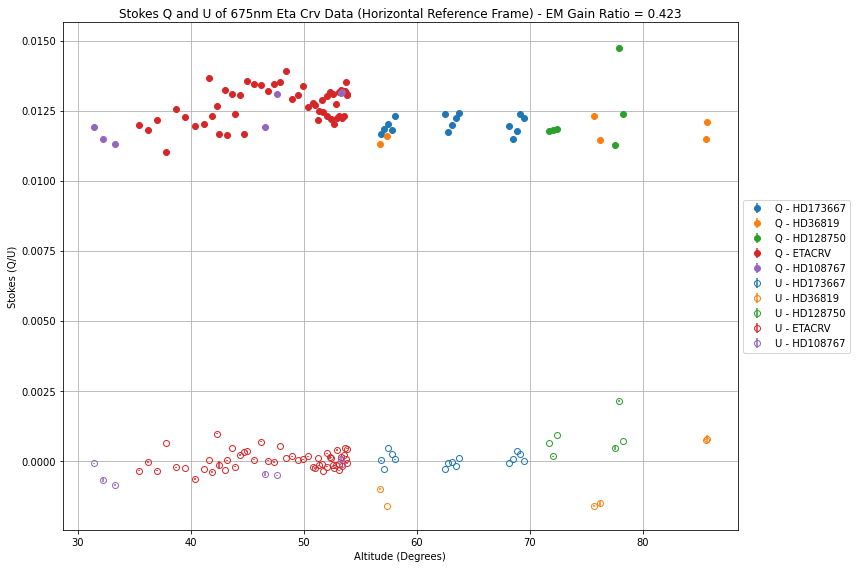

In [22]:
# Extract unique objects and generate colors
unique_objects = all_data['OBJECT'].unique()
colors = itertools.cycle(plt.cm.tab10.colors)  # Use a colormap with a cycle of 10 colors

# Initialize lists for storing the results
wavelength = 675
Q_list = []
U_list = []
Q_err_list = []
U_err_list = []
final_altitudes = []

model = matrices.full_system_mueller_matrix

# Loop through each unique object
for obj in unique_objects:
    object_data = all_data[all_data['OBJECT'] == obj]
    color = next(colors)

    # Initialize lists for this object
    first_rows = []
    inst_matrices_at_HWP = []
    this_cycle_intensities = []
    this_cycle_altitudes = []
    this_cycle_errors = []

    for i, row in object_data.iterrows():
        HWP_ang = row["U_HWPANG"]
        IMR_ang = row["D_IMRANG"]
        cam_num = row["U_CAMERA"]
        FLC_state = row["U_FLCSTT"]
        altitude = row["ALTITUDE"]
        parang = row["PA"]
        data_Q = row["Q"]

        # NOTE: This is for normalized differences
        double_difference = row["DOUBLE_DIFFERENCE"]
        double_sum = row["DOUBLE_SUM"]
        double_difference_err = row["DOUBLE_DIFFERENCE_ERRS"]

        if double_difference != 0:
            # Append intensities and altitudes for this cycle
            this_cycle_intensities.append(double_difference)
            this_cycle_altitudes.append(altitude)
            this_cycle_errors.append(double_difference_err)

            print("Parallactic Angle: " + str(parang) + " Altitude: " + str(altitude) + " HWP Angle: " + str(HWP_ang) + " IMR Angle: " + str(IMR_ang))

            # Calculate instrument matrix for equatorial reference frame
            these_inst_matrices_at_HWP = matrices.full_system_mueller_matrix_normalized_double_diff_and_sum(
                model, fixed_params, 0, altitude, HWP_ang, IMR_ang, factor = double_diff_factor)
            # Calculate instrument matrix at HWP
            # these_inst_matrices_at_HWP = matrices.full_system_mueller_matrix_normalized_double_diff_and_sum(
            #     model, fixed_params, 0, 0, HWP_ang, IMR_ang, factor = double_diff_factor)
            double_diff_matrix_at_HWP = these_inst_matrices_at_HWP[0]
            double_sum_matrix_at_HWP = these_inst_matrices_at_HWP[1]

            # Setting the I component to be 1
            double_diff_matrix_at_HWP[0, 0] = 1

            # Saving instrument matrices
            inst_matrices_at_HWP.append(double_diff_matrix_at_HWP)
            inst_matrices_at_HWP.append(double_sum_matrix_at_HWP)

            # Take only the first row and I, Q, U, components (no V)
            first_rows.append(double_diff_matrix_at_HWP[0, : 3])  

        # Do one inversion for one HWP cycle
        if data_Q != 0:
            # Constructing measurement matrix to reconstruct Stokes vector at HWP
            measurement_matrix = np.vstack(first_rows)
            measurements = np.array(this_cycle_intensities).reshape(-1, 1)  # Reshape total counts to a column vector
            errors = np.array(this_cycle_errors).reshape(-1, 1)  # Reshape errors to a column vector

            # Compute the pseudo-inverse of the measurement matrix and multiply it by the measurements vector
            s_HWP = np.linalg.pinv(measurement_matrix) @ measurements

            # Compute the errors for the Stokes parameters
            s_HWP_err = np.linalg.pinv(measurement_matrix) @ errors

            # Extract Q and U from s_HWP and their errors
            Q = s_HWP[1]
            U = s_HWP[2]
            Q_err = s_HWP_err[1]
            U_err = s_HWP_err[2]

            # Append Q, U, altitude, and errors to the lists
            Q_list.append((altitude, Q, color, obj))
            U_list.append((altitude, U, color, obj))
            Q_err_list.append(Q_err)
            U_err_list.append(U_err)

            # Saving the mean of the altitudes
            mean_altitude = np.mean(this_cycle_altitudes)

            # Reset measurement matrix rows and double diff and sum measurements
            first_rows = []  
            this_cycle_intensities = []
            this_cycle_altitudes = []
            this_cycle_errors = []

            final_altitudes.append(mean_altitude)

# TODO: See if it's ok to just take the absolute uncertainties
Q_err_list = np.abs(Q_err_list)
U_err_list = np.abs(U_err_list)

# Plotting
plt.figure(figsize=(12, 8))
plotted_labels = set()
for (altitude, Q, color, obj), Q_err in zip(Q_list, Q_err_list):
    label = f'Q - {obj}' if f'Q - {obj}' not in plotted_labels else None
    plt.errorbar(altitude, Q, yerr=Q_err, label=label, linestyle='None', marker='o', color=color, markerfacecolor=color)
    plotted_labels.add(f'Q - {obj}')

for (altitude, U, color, obj), U_err in zip(U_list, U_err_list):
    label = f'U - {obj}' if f'U - {obj}' not in plotted_labels else None
    plt.errorbar(altitude, U, yerr=U_err, label=label, linestyle='None', marker='o', color=color, markerfacecolor='none', markeredgecolor=color)
    plotted_labels.add(f'U - {obj}')

plt.title(f"Stokes Q and U of {wavelength}nm Eta Crv Data (Horizontal Reference Frame) - EM Gain Ratio = " + str(em_gain))
plt.xlabel("Altitude (Degrees)")
plt.ylabel("Stokes (Q/U)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
plt.show()


# Printing Some Matrices

In [23]:
# m3_with_rotations(delta_m3, epsilon_m3, offset, parang, altitude)
print(matrices.m3_with_rotations(0, 0, 0, 0, 0))
print(matrices.m3_with_rotations(0, 0.01, 0, 0, 0))

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
[[1.      0.01    0.      0.     ]
 [0.01    1.      0.      0.     ]
 [0.      0.      0.99995 0.     ]
 [0.      0.      0.      0.99995]]


In [24]:
delta_m3 = 0.5 # (waves) - assumed to be zero for now
epsilon_m3 = 0.0125  # Rough value from unpolarized standards fit
offset_m3 = -2.5  # NOTE: Made this zero too for testing purposes
em_gain = 0.423  # Add your actual em_gain value
delta_HWP = 0.451  # Add your actual delta_HWP value
offset_HWP = -2.642  # Add your actual offset_HWP value
delta_derot = 0.32  # Add your actual delta_derot value
offset_derot = -0.011  # Add your actual offset_derot value
delta_opts = -0.163  # Add your actual delta_opts value
epsilon_opts = 0.036  # Add your actual epsilon_opts value
rot_opts = -7.151  # Add your actual rot_opts value
delta_FLC = 0.302  # Add your actual delta_FLC value
rot_FLC = 0.256  # Add your actual rot_FLC value

parang = 0
altitude = 0
HWP_ang = 0
IMR_ang = 0
cam_num = 1
FLC_state = 1

# full_system_mueller_matrix( 
    # delta_m3, epsilon_m3, offset_m3, delta_HWP, offset_HWP, delta_derot, 
    # offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, rot_FLC, 
    # em_gain, parang, altitude, HWP_ang, IMR_ang, cam_num, FLC_state)

print(matrices.full_system_mueller_matrix( 
    delta_m3, 0.5, -2.5, delta_HWP, offset_HWP, delta_derot, 
    offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, rot_FLC, 
    em_gain, parang, altitude, HWP_ang, IMR_ang, cam_num, FLC_state))
print((matrices.full_system_mueller_matrix( 
    delta_m3, 0.5, -2.5, delta_HWP, offset_HWP, delta_derot, 
    offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, rot_FLC, 
    em_gain, parang, altitude, HWP_ang, IMR_ang, cam_num, FLC_state) @ np.array([1, 0, 0, 0]).reshape(-1, 1)))
print(matrices.full_system_mueller_matrix( 
    delta_m3, 0, -2.5, delta_HWP, offset_HWP, delta_derot, 
    offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, rot_FLC, 
    em_gain, parang, altitude, HWP_ang, IMR_ang, cam_num, FLC_state))
print(matrices.full_system_mueller_matrix( 
    delta_m3, 0, -2.5, delta_HWP, offset_HWP, delta_derot, 
    offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, rot_FLC, 
    em_gain, parang, altitude, HWP_ang, IMR_ang, cam_num, FLC_state) @ np.array([1, 0, 0, 0]).reshape(-1, 1))

[[ 0.32174911  0.31521565  0.06059112 -0.02214264]
 [ 0.32174911  0.31521565  0.06059112 -0.02214264]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
[[0.32174911]
 [0.32174911]
 [0.        ]
 [0.        ]]
[[ 0.21885504  0.20578813  0.06996459 -0.02556812]
 [ 0.21885504  0.20578813  0.06996459 -0.02556812]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
[[0.21885504]
 [0.21885504]
 [0.        ]
 [0.        ]]


In [25]:

delta_m3 = 0.5 # (waves) - assumed to be zero for now
epsilon_m3 = 0.0125  # Rough value from unpolarized standards fit
offset_m3 = -2.5  # NOTE: Made this zero too for testing purposes
em_gain = 0.423  # Add your actual em_gain value
delta_HWP = 0.451  # Add your actual delta_HWP value
offset_HWP = -2.642  # Add your actual offset_HWP value
delta_derot = 0.32  # Add your actual delta_derot value
offset_derot = -0.011  # Add your actual offset_derot value
delta_opts = -0.163  # Add your actual delta_opts value
epsilon_opts = 0.036  # Add your actual epsilon_opts value
rot_opts = -7.151  # Add your actual rot_opts value
delta_FLC = 0.302  # Add your actual delta_FLC value
rot_FLC = 0.256  # Add your actual rot_FLC value

# For changing certain parameters
# delta_FLC = 0.5
# em_gain = 1 / 1.08
epsilon_m3 = 0.0125
# epsilon_opts = 0 # Made this zero for testing purposes

fixed_params = [delta_m3, epsilon_m3, offset_m3, delta_HWP, offset_HWP, 
    delta_derot, offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, 
    rot_FLC, em_gain]

model = matrices.full_system_mueller_matrix
print(matrices.full_system_mueller_matrix_normalized_double_diff_and_sum(
    model, fixed_params, 0, altitude, HWP_ang, IMR_ang, factor = double_diff_factor)[0] @ np.array([1, 0, 0, 0]).reshape(-1, 1))

delta_m3 = 0.5 # (waves) - assumed to be zero for now
epsilon_m3 = 0.0125  # Rough value from unpolarized standards fit
offset_m3 = -2.5  # NOTE: Made this zero too for testing purposes
em_gain = 0.423  # Add your actual em_gain value
delta_HWP = 0.451  # Add your actual delta_HWP value
offset_HWP = -2.642  # Add your actual offset_HWP value
delta_derot = 0.32  # Add your actual delta_derot value
offset_derot = -0.011  # Add your actual offset_derot value
delta_opts = -0.163  # Add your actual delta_opts value
epsilon_opts = 0.036  # Add your actual epsilon_opts value
rot_opts = -7.151  # Add your actual rot_opts value
delta_FLC = 0.302  # Add your actual delta_FLC value
rot_FLC = 0.256  # Add your actual rot_FLC value

fixed_params = [delta_m3, epsilon_m3, offset_m3, delta_HWP, offset_HWP, 
    delta_derot, offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, 
    rot_FLC, em_gain]

# For changing certain parameters
# delta_FLC = 0.5
# em_gain = 1 / 1.08
epsilon_m3 = 0.25
# epsilon_opts = 0 # Made this zero for testing purposes

# For figuring out the correrct factor for the double diff matrix

print(matrices.full_system_mueller_matrix_normalized_double_diff_and_sum(
    model, fixed_params, 0, altitude, HWP_ang, IMR_ang, factor = double_diff_factor)[0] @ np.array([1, 0, 0, 0]).reshape(-1, 1))

[[ 0.04607955]
 [-0.0186844 ]
 [ 0.        ]
 [ 0.        ]]
[[ 0.04607955]
 [-0.0186844 ]
 [ 0.        ]
 [ 0.        ]]


# Adding M3

In [26]:
# Internal Calibration Model Parameters from MCMC best fit value - 
# https://docs.google.com/spreadsheets/d/1i8TjHzQFMmxaUWrrqm1eYziyUanC6pweGGFzJPdfbiE/edit#gid=0

delta_m3 = 0.5 # (waves) - assumed to be zero for now
epsilon_m3 = 0.0125  # Rough value from unpolarized standards fit
offset_m3 = -2.5  # NOTE: Made this zero too for testing purposes
em_gain = 0.423  # Add your actual em_gain value
delta_HWP = 0.451  # Add your actual delta_HWP value
offset_HWP = -2.642  # Add your actual offset_HWP value
delta_derot = 0.32  # Add your actual delta_derot value
offset_derot = -0.011  # Add your actual offset_derot value
delta_opts = -0.163  # Add your actual delta_opts value
epsilon_opts = 0.036  # Add your actual epsilon_opts value
rot_opts = -7.151  # Add your actual rot_opts value
delta_FLC = 0.302  # Add your actual delta_FLC value
rot_FLC = 0.256  # Add your actual rot_FLC value

# For figuring out the correrct factor for the double diff matrix

fixed_params = [delta_m3, epsilon_m3, offset_m3, delta_HWP, offset_HWP, 
    delta_derot, offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, 
    rot_FLC, em_gain]

print(epsilon_m3)

0.0125


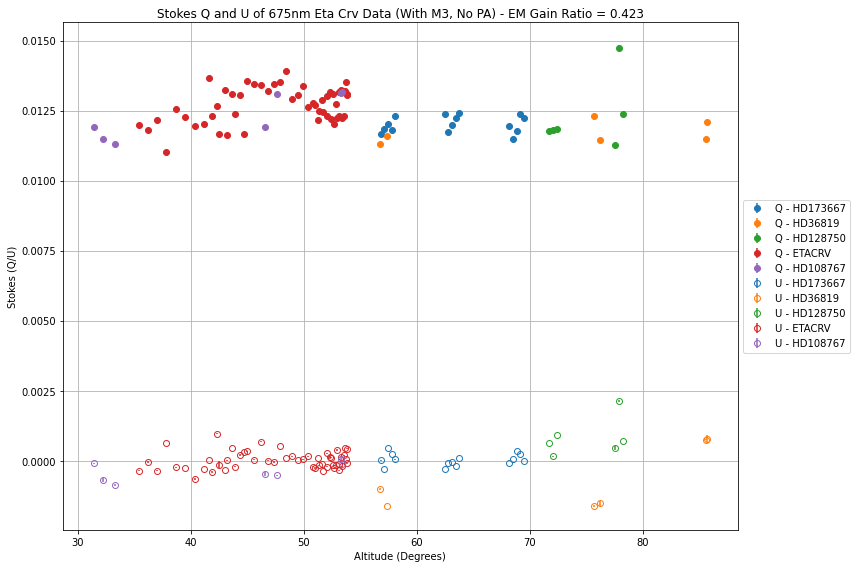

In [27]:
# Extract unique objects and generate colors
unique_objects = all_data['OBJECT'].unique()
colors = itertools.cycle(plt.cm.tab10.colors)  # Use a colormap with a cycle of 10 colors

# Initialize lists for storing the results
wavelength = 675
Q_list = []
U_list = []
Q_err_list = []
U_err_list = []
final_altitudes = []

model = matrices.full_system_mueller_matrix

# Loop through each unique object
for obj in unique_objects:
    object_data = all_data[all_data['OBJECT'] == obj]
    color = next(colors)

    # Initialize lists for this object
    first_rows = []
    inst_matrices_at_HWP = []
    this_cycle_intensities = []
    this_cycle_altitudes = []
    this_cycle_errors = []

    for i, row in object_data.iterrows():
        HWP_ang = row["U_HWPANG"]
        IMR_ang = row["D_IMRANG"]
        cam_num = row["U_CAMERA"]
        FLC_state = row["U_FLCSTT"]
        altitude = row["ALTITUDE"]
        parang = row["PA"]
        data_Q = row["Q"]

        # NOTE: This is for normalized differences
        double_difference = row["DOUBLE_DIFFERENCE"]
        double_sum = row["DOUBLE_SUM"]
        double_difference_err = row["DOUBLE_DIFFERENCE_ERRS"]

        if double_difference != 0:
            # Append intensities and altitudes for this cycle
            this_cycle_intensities.append(double_difference)
            this_cycle_altitudes.append(altitude)
            this_cycle_errors.append(double_difference_err)

            #print("Parallactic Angle: " + str(parang) + " Altitude: " + str(altitude) + " HWP Angle: " + str(HWP_ang) + " IMR Angle: " + str(IMR_ang))

            delta_m3 = 0.5 # (waves) - assumed to be zero for now
            epsilon_m3 = 0.0125  # Rough value from unpolarized standards fit
            offset_m3 = -2.5  # NOTE: Made this zero too for testing purposes
            fixed_params = [delta_m3, epsilon_m3, offset_m3, delta_HWP, offset_HWP, 
                delta_derot, offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, 
                rot_FLC, em_gain]

            # Calculate instrument matrix for equatorial reference frame
            these_inst_matrices_at_HWP = matrices.full_system_mueller_matrix_normalized_double_diff_and_sum(
                model, fixed_params, 0, altitude, HWP_ang, IMR_ang, factor = double_diff_factor)
            delta_m3 = 0.5 # (waves) - assumed to be zero for now
            epsilon_m3 = 0  # Rough value from unpolarized standards fit
            offset_m3 = -2.5  # NOTE: Made this zero too for testing purposes
            fixed_params = [delta_m3, epsilon_m3, offset_m3, delta_HWP, offset_HWP, 
                delta_derot, offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, 
                rot_FLC, em_gain]
            these_inst_matrices_no_m3 = matrices.full_system_mueller_matrix_normalized_double_diff_and_sum(
                model, fixed_params, 0, altitude, HWP_ang, IMR_ang, factor = double_diff_factor)
            # Calculate instrument matrix at HWP
            # these_inst_matrices_at_HWP = matrices.full_system_mueller_matrix_normalized_double_diff_and_sum(
            #     model, fixed_params, 0, 0, HWP_ang, IMR_ang, factor = double_diff_factor)
            double_diff_matrix_at_HWP = these_inst_matrices_at_HWP[0]
            double_sum_matrix_at_HWP = these_inst_matrices_at_HWP[1]

            # Setting the I component to be 1
            double_diff_matrix_at_HWP[0, 0] = 1

            # Saving instrument matrices
            inst_matrices_at_HWP.append(double_diff_matrix_at_HWP)
            inst_matrices_at_HWP.append(double_sum_matrix_at_HWP)

            # Take only the first row and I, Q, U, components (no V)
            first_rows.append(double_diff_matrix_at_HWP[0, : 3])  

        # Do one inversion for one HWP cycle
        if data_Q != 0:
            # Constructing measurement matrix to reconstruct Stokes vector at HWP
            measurement_matrix = np.vstack(first_rows)
            measurements = np.array(this_cycle_intensities).reshape(-1, 1)  # Reshape total counts to a column vector
            errors = np.array(this_cycle_errors).reshape(-1, 1)  # Reshape errors to a column vector

            # Compute the pseudo-inverse of the measurement matrix and multiply it by the measurements vector
            s_HWP = np.linalg.pinv(measurement_matrix) @ measurements

            # Compute the errors for the Stokes parameters
            s_HWP_err = np.linalg.pinv(measurement_matrix) @ errors

            # Extract Q and U from s_HWP and their errors
            Q = s_HWP[1]
            U = s_HWP[2]
            Q_err = s_HWP_err[1]
            U_err = s_HWP_err[2]

            # Append Q, U, altitude, and errors to the lists
            Q_list.append((altitude, Q, color, obj))
            U_list.append((altitude, U, color, obj))
            Q_err_list.append(Q_err)
            U_err_list.append(U_err)

            # Saving the mean of the altitudes
            mean_altitude = np.mean(this_cycle_altitudes)

            # Reset measurement matrix rows and double diff and sum measurements
            first_rows = []  
            this_cycle_intensities = []
            this_cycle_altitudes = []
            this_cycle_errors = []

            final_altitudes.append(mean_altitude)

# TODO: See if it's ok to just take the absolute uncertainties
Q_err_list = np.abs(Q_err_list)
U_err_list = np.abs(U_err_list)

# Plotting
plt.figure(figsize=(12, 8))
plotted_labels = set()
for (altitude, Q, color, obj), Q_err in zip(Q_list, Q_err_list):
    label = f'Q - {obj}' if f'Q - {obj}' not in plotted_labels else None
    plt.errorbar(altitude, Q, yerr=Q_err, label=label, linestyle='None', marker='o', color=color, markerfacecolor=color)
    plotted_labels.add(f'Q - {obj}')

for (altitude, U, color, obj), U_err in zip(U_list, U_err_list):
    label = f'U - {obj}' if f'U - {obj}' not in plotted_labels else None
    plt.errorbar(altitude, U, yerr=U_err, label=label, linestyle='None', marker='o', color=color, markerfacecolor='none', markeredgecolor=color)
    plotted_labels.add(f'U - {obj}')

# print("Instrument Matrix with M3: " + str(these_inst_matrices_at_HWP))
# print("Instrument Matrix without M3: " + str(these_inst_matrices_no_m3))

plt.title(f"Stokes Q and U of {wavelength}nm Eta Crv Data (With M3, No PA) - EM Gain Ratio = " + str(em_gain))
plt.xlabel("Altitude (Degrees)")
plt.ylabel("Stokes (Q/U)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
plt.show()


In [32]:
# With M3
epsilon_m3 = 0.01
delta_m3 = 0.5
HWP_ang = 22.5
print(HWP_ang)
print(altitude)
FL1 = matrices.full_system_mueller_matrix( 
    delta_m3, epsilon_m3, offset_m3, delta_HWP, offset_HWP, delta_derot, 
    offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, rot_FLC, 
    em_gain, parang, altitude, HWP_ang, IMR_ang, 1, 1)
FL2 = matrices.full_system_mueller_matrix( 
    delta_m3, epsilon_m3, offset_m3, delta_HWP, offset_HWP, delta_derot, 
    offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, rot_FLC, 
    em_gain, parang, altitude, HWP_ang, IMR_ang, 1, 2)
FR1 = matrices.full_system_mueller_matrix( 
    delta_m3, epsilon_m3, offset_m3, delta_HWP, offset_HWP, delta_derot, 
    offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, rot_FLC, 
    em_gain, parang, altitude, HWP_ang, IMR_ang, 2, 1)
FR2 = matrices.full_system_mueller_matrix( 
    delta_m3, epsilon_m3, offset_m3, delta_HWP, offset_HWP, delta_derot, 
    offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, rot_FLC, 
    em_gain, parang, altitude, HWP_ang, IMR_ang, 2, 2)

# Printing M3 matrices

print("FL1: " + str(FL1[0 , :]))
print("FL2: " + str(FL2[0 , :]))
print("FR1: " + str(FR1[0 , :]))
print("FR2: " + str(FR2[0 , :]))

double_diff = ((FL1 - FR1) - (FL2 - FR2))
print("Double Diff: " + str(double_diff[0 , :]))

# No M3
epsilon_m3 = 0
delta_m3 = 0.5
FL1_no_m3 = matrices.full_system_mueller_matrix( 
    delta_m3, epsilon_m3, offset_m3, delta_HWP, offset_HWP, delta_derot, 
    offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, rot_FLC, 
    em_gain, parang, altitude, HWP_ang, IMR_ang, 1, 1)
FL2_no_m3 = matrices.full_system_mueller_matrix( 
    delta_m3, epsilon_m3, offset_m3, delta_HWP, offset_HWP, delta_derot, 
    offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, rot_FLC, 
    em_gain, parang, altitude, HWP_ang, IMR_ang, 1, 2)
FR1_no_m3 = matrices.full_system_mueller_matrix( 
    delta_m3, epsilon_m3, offset_m3, delta_HWP, offset_HWP, delta_derot, 
    offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, rot_FLC, 
    em_gain, parang, altitude, HWP_ang, IMR_ang, 2, 1)
FR2_no_m3 = matrices.full_system_mueller_matrix( 
    delta_m3, epsilon_m3, offset_m3, delta_HWP, offset_HWP, delta_derot, 
    offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, rot_FLC, 
    em_gain, parang, altitude, HWP_ang, IMR_ang, 2, 2)

# Printing no M3 matrices

print("FL1 (No M3): " + str(FL1_no_m3[0 , :]))
print("FL2 (No M3): " + str(FL2_no_m3[0 , :]))
print("FR1 (No M3): " + str(FR1_no_m3[0 , :]))
print("FR2 (No M3): " + str(FR2_no_m3[0 , :]))

double_diff_no_m3 = ((FL1_no_m3 - FR1_no_m3) - (FL2_no_m3 - FR2_no_m3))
print("Double Diff (No M3): " + str(double_diff_no_m3[0 , :]))

22.5
53.31294
FL1: [0.22068838 0.16342072 0.11391023 0.0949815 ]
FL2: [ 0.20777768 -0.12454726 -0.06223609  0.1542278 ]
FR1: [ 0.4785415  -0.35568259 -0.24132418 -0.21036754]
FR2: [ 0.50906325  0.32509277  0.1750974  -0.3504297 ]
Double Diff: [ 0.04343244  0.96874335  0.59256791 -0.19930845]
FL1 (No M3): [0.21885504 0.16129197 0.11340212 0.09498625]
FL2 (No M3): [ 0.20915505 -0.12658048 -0.06272659  0.15423551]
FR1 (No M3): [ 0.4826122  -0.36037321 -0.2424598  -0.21037806]
FR2 (No M3): [ 0.50554361  0.32017633  0.17392012 -0.35044723]
Double Diff (No M3): [ 0.03263141  0.96842199  0.59250862 -0.19931842]


# Plotting in Equatorial Reference Frame

In [ ]:
# Internal Calibration Model Parameters from MCMC best fit value - 
# https://docs.google.com/spreadsheets/d/1i8TjHzQFMmxaUWrrqm1eYziyUanC6pweGGFzJPdfbiE/edit#gid=0

delta_m3 = 0.5 # (waves) - assumed to be zero for now
epsilon_m3 = 0.0125  # Rough value from unpolarized standards fit
offset_m3 = -2.5  # NOTE: Made this zero too for testing purposes
em_gain = 0.423  # Add your actual em_gain value
delta_HWP = 0.451  # Add your actual delta_HWP value
offset_HWP = -2.642  # Add your actual offset_HWP value
delta_derot = 0.32  # Add your actual delta_derot value
offset_derot = -0.011  # Add your actual offset_derot value
delta_opts = -0.163  # Add your actual delta_opts value
epsilon_opts = 0.036  # Add your actual epsilon_opts value
rot_opts = -7.151  # Add your actual rot_opts value
delta_FLC = 0.302  # Add your actual delta_FLC value
rot_FLC = 0.256  # Add your actual rot_FLC value

# For changing certain parameters
# delta_FLC = 0.5
# em_gain = 1 / 1.08
# epsilon_opts = 0 # Made this zero for testing purposes

fixed_params = [delta_m3, epsilon_m3, offset_m3, delta_HWP, offset_HWP, 
    delta_derot, offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, 
    rot_FLC, em_gain]

Parallactic Angle: -84.9084509958819 Altitude: 56.56625 HWP Angle: 0.0 IMR Angle: 92.72502
Parallactic Angle: -84.92782440447132 Altitude: 56.6469 HWP Angle: 45.0 IMR Angle: 92.75622
Parallactic Angle: -84.94601513329397 Altitude: 56.72251 HWP Angle: 22.5 IMR Angle: 92.774
Parallactic Angle: -84.96558157041534 Altitude: 56.80395 HWP Angle: 67.5 IMR Angle: 92.83803
Parallactic Angle: -84.98557673519853 Altitude: 56.88694 HWP Angle: 0.0 IMR Angle: 92.88425
Parallactic Angle: -85.00475344133699 Altitude: 56.96644 HWP Angle: 45.0 IMR Angle: 92.9218
Parallactic Angle: -85.02352809078987 Altitude: 57.04475 HWP Angle: 22.5 IMR Angle: 92.96298
Parallactic Angle: -85.04303906901262 Altitude: 57.1258 HWP Angle: 67.5 IMR Angle: 93.00444
Parallactic Angle: -85.06352335313669 Altitude: 57.21077 HWP Angle: 0.0 IMR Angle: 93.04548
Parallactic Angle: -85.08298858276943 Altitude: 57.29144 HWP Angle: 45.0 IMR Angle: 93.07996
Parallactic Angle: -85.1012730269808 Altitude: 57.36742 HWP Angle: 22.5 IMR Ang

Parallactic Angle: 170.1471114528957 Altitude: 85.75207 HWP Angle: 0.0 IMR Angle: 107.36972
Parallactic Angle: 167.6205632422972 Altitude: 85.72787 HWP Angle: 45.0 IMR Angle: 107.36969
Parallactic Angle: 166.0440630229906 Altitude: 85.70915 HWP Angle: 22.5 IMR Angle: 107.3604
Parallactic Angle: 164.4404652272129 Altitude: 85.68556 HWP Angle: 67.5 IMR Angle: 107.35025
Parallactic Angle: 162.8602984217002 Altitude: 85.65928 HWP Angle: 0.0 IMR Angle: 107.32678
Parallactic Angle: 161.3511163687652 Altitude: 85.62945 HWP Angle: 45.0 IMR Angle: 107.29972
Parallactic Angle: 159.9613111783035 Altitude: 85.59906 HWP Angle: 22.5 IMR Angle: 107.29972
Parallactic Angle: 158.4575288535741 Altitude: 85.56379 HWP Angle: 67.5 IMR Angle: 107.28274
Parallactic Angle: 105.2299474619039 Altitude: 76.59692 HWP Angle: 0.0 IMR Angle: 102.80188
Parallactic Angle: 104.9478705038061 Altitude: 76.41757 HWP Angle: 45.0 IMR Angle: 102.72373
Parallactic Angle: 104.7780572987302 Altitude: 76.3035 HWP Angle: 22.5 IMR

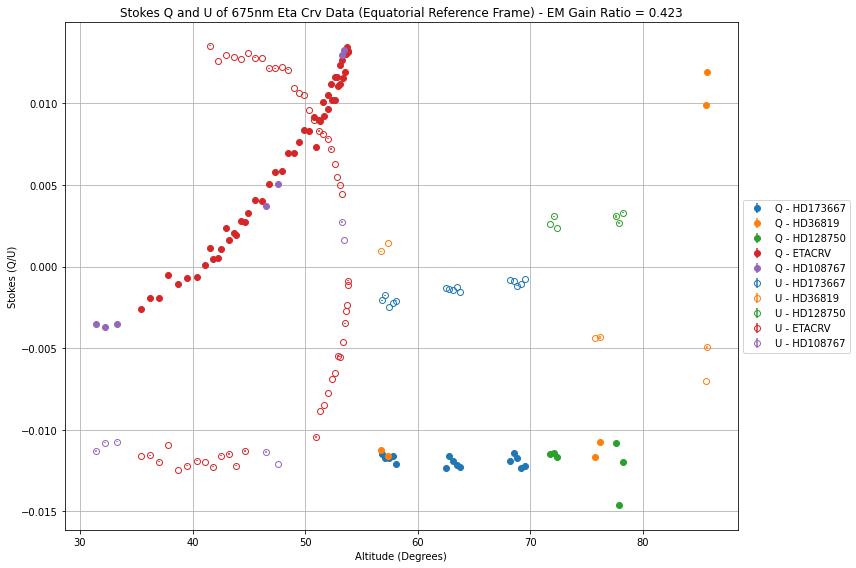

In [ ]:
# Extract unique objects and generate colors
unique_objects = all_data['OBJECT'].unique()
colors = itertools.cycle(plt.cm.tab10.colors)  # Use a colormap with a cycle of 10 colors

# Initialize lists for storing the results
wavelength = 675
Q_list = []
U_list = []
Q_err_list = []
U_err_list = []
final_altitudes = []

model = matrices.full_system_mueller_matrix

# Loop through each unique object
for obj in unique_objects:
    object_data = all_data[all_data['OBJECT'] == obj]
    color = next(colors)

    # Initialize lists for this object
    first_rows = []
    inst_matrices_at_HWP = []
    this_cycle_intensities = []
    this_cycle_altitudes = []
    this_cycle_errors = []

    for i, row in object_data.iterrows():
        HWP_ang = row["U_HWPANG"]
        IMR_ang = row["D_IMRANG"]
        cam_num = row["U_CAMERA"]
        FLC_state = row["U_FLCSTT"]
        altitude = row["ALTITUDE"]
        parang = row["PA"]
        data_Q = row["Q"]

        # NOTE: This is for normalized differences
        double_difference = row["DOUBLE_DIFFERENCE"]
        double_sum = row["DOUBLE_SUM"]
        double_difference_err = row["DOUBLE_DIFFERENCE_ERRS"]

        if double_difference != 0:
            # Append intensities and altitudes for this cycle
            this_cycle_intensities.append(double_difference)
            this_cycle_altitudes.append(altitude)
            this_cycle_errors.append(double_difference_err)

            print("Parallactic Angle: " + str(parang) + " Altitude: " + str(altitude) + " HWP Angle: " + str(HWP_ang) + " IMR Angle: " + str(IMR_ang))

            # Calculate instrument matrix for equatorial reference frame
            these_inst_matrices_at_HWP = matrices.full_system_mueller_matrix_normalized_double_diff_and_sum(
                model, fixed_params, parang, altitude, HWP_ang, IMR_ang, factor = double_diff_factor)
            # Calculate instrument matrix at HWP
            # these_inst_matrices_at_HWP = matrices.full_system_mueller_matrix_normalized_double_diff_and_sum(
            #     model, fixed_params, 0, 0, HWP_ang, IMR_ang, factor = double_diff_factor)
            double_diff_matrix_at_HWP = these_inst_matrices_at_HWP[0]
            double_sum_matrix_at_HWP = these_inst_matrices_at_HWP[1]

            # Setting the I component to be 1
            double_diff_matrix_at_HWP[0, 0] = 1

            # Saving instrument matrices
            inst_matrices_at_HWP.append(double_diff_matrix_at_HWP)
            inst_matrices_at_HWP.append(double_sum_matrix_at_HWP)

            # Take only the first row and I, Q, U, components (no V)
            first_rows.append(double_diff_matrix_at_HWP[0, : 3])  

        # Do one inversion for one HWP cycle
        if data_Q != 0:
            # Constructing measurement matrix to reconstruct Stokes vector at HWP
            measurement_matrix = np.vstack(first_rows)
            measurements = np.array(this_cycle_intensities).reshape(-1, 1)  # Reshape total counts to a column vector
            errors = np.array(this_cycle_errors).reshape(-1, 1)  # Reshape errors to a column vector

            # Compute the pseudo-inverse of the measurement matrix and multiply it by the measurements vector
            s_HWP = np.linalg.pinv(measurement_matrix) @ measurements

            # Compute the errors for the Stokes parameters
            s_HWP_err = np.linalg.pinv(measurement_matrix) @ errors

            # Extract Q and U from s_HWP and their errors
            Q = s_HWP[1]
            U = s_HWP[2]
            Q_err = s_HWP_err[1]
            U_err = s_HWP_err[2]

            # Append Q, U, altitude, and errors to the lists
            Q_list.append((altitude, Q, color, obj))
            U_list.append((altitude, U, color, obj))
            Q_err_list.append(Q_err)
            U_err_list.append(U_err)

            # Saving the mean of the altitudes
            mean_altitude = np.mean(this_cycle_altitudes)

            # Reset measurement matrix rows and double diff and sum measurements
            first_rows = []  
            this_cycle_intensities = []
            this_cycle_altitudes = []
            this_cycle_errors = []

            final_altitudes.append(mean_altitude)

# TODO: See if it's ok to just take the absolute uncertainties
Q_err_list = np.abs(Q_err_list)
U_err_list = np.abs(U_err_list)

# Plotting
plt.figure(figsize=(12, 8))
plotted_labels = set()
for (altitude, Q, color, obj), Q_err in zip(Q_list, Q_err_list):
    label = f'Q - {obj}' if f'Q - {obj}' not in plotted_labels else None
    plt.errorbar(altitude, Q, yerr=Q_err, label=label, linestyle='None', marker='o', color=color, markerfacecolor=color)
    plotted_labels.add(f'Q - {obj}')

for (altitude, U, color, obj), U_err in zip(U_list, U_err_list):
    label = f'U - {obj}' if f'U - {obj}' not in plotted_labels else None
    plt.errorbar(altitude, U, yerr=U_err, label=label, linestyle='None', marker='o', color=color, markerfacecolor='none', markeredgecolor=color)
    plotted_labels.add(f'U - {obj}')

plt.title(f"Stokes Q and U of {wavelength}nm Eta Crv Data (Equatorial Reference Frame) - EM Gain Ratio = " + str(em_gain))
plt.xlabel("Altitude (Degrees)")
plt.ylabel("Stokes (Q/U)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
plt.show()
